In [23]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [26]:
import itertools
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from src.utils import one_hot
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.directory import data_dir, NHANES_preprocessed_filename

In [24]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.serif'] = ['Times New Roman']

In [39]:
# load df
NHANES_preprocessed_filepath = os.path.join(data_dir, NHANES_preprocessed_filename)
df = pd.read_csv(NHANES_preprocessed_filepath, index_col='SEQN')

In [40]:
df.dropna(how='any', inplace=True)
df = df[df['age']>=35]
df.rename(columns={'martial_status': 'marital_status'}, inplace=True)
print('# patients with complete data: ', len(df))

# patients with complete data:  2547


In [41]:
df['sleep_deprivation'].value_counts()

sleep_deprivation
1.0    1303
0.0     872
2.0     372
Name: count, dtype: int64

In [42]:
df['HTN'].value_counts()

HTN
1.0    1641
0.0     906
Name: count, dtype: int64

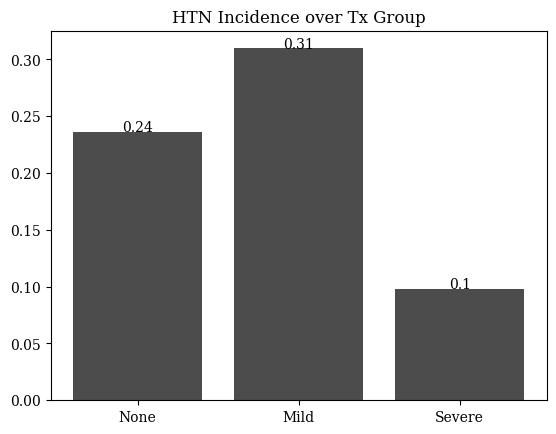

In [43]:
x = ['None', 'Mild', 'Severe']
y = [sum(df.loc[df['sleep_deprivation']==0, 'HTN'])/len(df['sleep_deprivation']==0), 
     sum(df.loc[df['sleep_deprivation']==1, 'HTN'])/len(df['sleep_deprivation']==1),
     sum(df.loc[df['sleep_deprivation']==2, 'HTN'])/len(df['sleep_deprivation']==2)]

plt.bar(x,y, color = 'black', alpha=0.7)
plt.title('HTN Incidence over Tx Group')

for index, value in enumerate(y):
    plt.text(index, value, str(round(value, 2)),  ha='center')

In [44]:
# define relevant features
# features
z_col = 'ambient_light'
t_col = 'sleep_deprivation'
y_cols = ['HTN', 'DBP', 'SBP']

# column types
categorical_cols = ['physical_activity', 'ANTIDEPRESSANTS_ANXIOLYTICS', 'GLUCOCORTICOIDS', 'sleep_troubles',
       'sleep_deprivation', 'diabetes', 'smoker', 'race_ethnicity', 'gender', 'health_insurance', 'marital_status','CVD', 
       'smoker_hx', 'HTN']
numerical_cols = ['daily_sedentary', 'accelerometer', 'BMI', 'age', 'poverty_ratio', 'depression', 'yearly_alcohol', 'DBP', 'SBP']

# columns not to transform
all_cols = df.columns
untransformed_cols = [x for x in all_cols if x in [*y_cols, t_col, z_col]]

In [45]:
# make z col binary (indicator of recommended max lux value during sleep)
light_cutoff = 1 # nightly minute-mean summed light exposure
df[z_col] = df[z_col].apply(lambda x: 1 if x <= light_cutoff else x)
df[z_col] = df[z_col].apply(lambda x: 0 if x > light_cutoff else x)

# one-hot encode multiclass categoricals
multiclass_cols = df[categorical_cols].columns[df[categorical_cols].nunique() > 2].tolist() 
categorical_transformation_cols = list(set(multiclass_cols) - set(untransformed_cols))

df = one_hot(df, categorical_transformation_cols)
df.columns = df.columns.str.replace('.0', '')

# get df as float
df = df.astype(float)

# get covariates
x_cols = list(set(df.columns) - set([t_col, *y_cols, z_col]))

# update lists of variable type
all_cols = df.columns
categorical_cols = [x for x in df.columns if any([x.startswith(y) for y in categorical_cols])]

In [46]:
class PropensityNet(nn.Module):
    # define simple propensity score nn
    # softmax final layer for multiple tx groups
    def __init__(self, input_dim, output_dim):
        super(PropensityNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

class OutcomeNet(nn.Module):
    # define binary outcome model nn
    def __init__(self, input_dim):
        super(OutcomeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


def train_propensity_nn(X, T, treatment_classes, epochs=100, lr=0.001):
    class_to_index = {cls: i for i, cls in enumerate(treatment_classes)}
    T_encoded = T.map(class_to_index)

    # scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    # T here is a single column for classification
    T_tensor = torch.tensor(T_encoded.values, dtype=torch.long)

    # cross entropy loss for propenstity score training
    model = PropensityNet(X.shape[1], len(treatment_classes))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    #train 
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_tensor)
        loss = criterion(logits, T_tensor)
        loss.backward()
        optimizer.step()

    # make tx class predictions
    with torch.no_grad():
        pi = model(X_tensor).numpy()
    
    return pi, model, scaler, class_to_index

def train_outcome_nn(X, T, Y, treatment_classes, epochs=100, lr=0.001):
    class_to_index = {cls: i for i, cls in enumerate(treatment_classes)}
    # T gets one hot encoded into multiple columns for outcome nn
    # so model can learn non-ordinal differences between tx groups
    T_encoded = T.map(class_to_index).values
    T_onehot = np.eye(len(treatment_classes))[T_encoded]
    XT = np.concatenate([X, T_onehot], axis=1)

    # scale features
    scaler = StandardScaler()
    XT_scaled = scaler.fit_transform(XT)

    X_tensor = torch.tensor(XT_scaled, dtype=torch.float32)
    Y_tensor = torch.tensor(Y.values, dtype=torch.float32).unsqueeze(1)

    model = OutcomeNet(XT.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # define binary cross entropy loss
    criterion = nn.BCELoss()

    # train
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_tensor)
        loss = criterion(y_pred, Y_tensor)
        loss.backward()
        optimizer.step()

    return model, scaler, class_to_index

def aipw_estimate(X, T, Y, pi, mu_model, scaler, treatment_classes, class_to_index):
    n = len(X)
    n_classes = len(treatment_classes)
    tau_i = {}
    mu = np.zeros((n, n_classes))

    # for each tx 
    for cls in treatment_classes:
        k = class_to_index[cls]
        # make a three column one-hot vector to hold all possible tx values
        T_k = np.eye(n_classes)[[k] * n]
        XT_k = np.concatenate([X, T_k], axis=1)
        # scale features
        XT_k_scaled = scaler.transform(XT_k)
        X_tensor = torch.tensor(XT_k_scaled, dtype=torch.float32)

        # get predictions
        with torch.no_grad():
            preds = mu_model(X_tensor).numpy().flatten()

        mu[:, k] = preds
        treated = (T == cls).astype(float).values
        # calculate ipw term
        ipw_term = treated / pi[:, k] * (Y.values - mu[:, k])
        # get adjusted predictions
        tau_i[k] = mu[:, k] + ipw_term

    results = {}
    for i, ci in enumerate(treatment_classes):
        for j, cj in enumerate(treatment_classes):
            if j <= i:
                continue
            tau_diff = tau_i[class_to_index[cj]] - tau_i[class_to_index[ci]]
            results[f"{cj} vs {ci}"] = {
                "tau": tau_diff.mean(),
                "variance": tau_diff.var()
            }

    return results, mu

def run_weighted_logistic_regression(df, treatment_col, outcome_col, pi, treatment_classes, class_to_index):
    T_encoded = df[treatment_col].map(class_to_index)
    Y = df[outcome_col].astype(float)
    T_dummies = pd.get_dummies(T_encoded, prefix='T', drop_first=True)
    X = sm.add_constant(T_dummies).astype(float)
    # inverse propensity weights from propensity preds
    weights = 1.0 / pi[np.arange(len(pi)), T_encoded]

    model = sm.Logit(Y, X)
    result = model.fit(weights=weights, disp=False)
    X.columns = ['Intercept'] + [f"{treatment_classes[int(c.split('_')[1])]} vs {treatment_classes[0]}" for c in T_dummies.columns]
    return result


In [177]:
# prep data
T = df["sleep_deprivation"]
Y = df["HTN"]
X = df[x_cols]
treatment_classes = sorted(df["sleep_deprivation"].unique())

# propensity model
pi, prop_model, prop_scaler, class_to_index = train_propensity_nn(X, T, treatment_classes)

# outcome model
mu_model, mu_scaler, _ = train_outcome_nn(X, T, Y, treatment_classes)

# get aipw estimates
results, mu = aipw_estimate(X, T, Y, pi, mu_model, mu_scaler, treatment_classes, class_to_index)

print("AIPW Results:")
for k, v in results.items():
    print(f"{k}: tau={v['tau']:.4f}, var={v['variance']:.4f}")


AIPW Results:
1.0 vs 0.0: tau=-0.0459, var=2.6807
2.0 vs 0.0: tau=-0.0328, var=5.4879
2.0 vs 1.0: tau=0.0131, var=3.0847


In [49]:
# calculate risk ratios and e-values for 
# unobserved confounding from aipw results
baseline_risk = mu[:, 0].mean()

def calculate_e_value(rr):
    if rr < 1:
        rr = 1 / rr
    return rr + np.sqrt(rr * (rr - 1))

print(f"Baseline risk (T=0): {baseline_risk:.3f}\n")

for comparison, result in results.items():
    if "0.0" not in comparison:
        continue  #only interested in baseline comparisons here
    tau = result["tau"]
    treated_risk = baseline_risk + tau
    rr = treated_risk / baseline_risk if baseline_risk > 0 else np.nan
    e_val = calculate_e_value(rr)
    print(f"{comparison}: Risk Ratio ≈ {rr:.3f}, E-value = {e_val:.3f}")


Baseline risk (T=0): 0.660

1.0 vs 0.0: Risk Ratio ≈ 0.942, E-value = 1.316
2.0 vs 0.0: Risk Ratio ≈ 0.961, E-value = 1.245


In [182]:
# make sure T is numerical here before passing to weighted
# logistic regression
df["T_encoded"] = df["sleep_deprivation"].map(class_to_index)
logit_result = run_weighted_logistic_regression(
    df=df,
    treatment_col="sleep_deprivation",
    outcome_col="HTN",
    pi=pi,
    treatment_classes=treatment_classes,
    class_to_index=class_to_index
)
logit_result.summary()

/scratch/users/melia/miniconda3/envs/cph200b_project3/lib/python3.11/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    HTN   No. Observations:                 2547
Model:                          Logit   Df Residuals:                     2544
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 Mar 2025   Pseudo R-squ.:                0.005409
Time:                        21:49:06   Log-Likelihood:                -1648.9
converged:                       True   LL-Null:                       -1657.9
Covariance Type:            nonrobust   LLR p-value:                 0.0001275
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8018      0.073     10.947      0.000       0.658       0.945
1.0 vs 0.0    -0.3733      0.093     -4.031      0.000      -0.555      -0.192
2.0 vs 0.0    -0.0844      0.133     -0.637      0.524      -0.344       0.175
==============================================================================
"""

In [50]:
# bootstrap function to get more reliable aipw results
def bootstrap_aipw_nn(data, treatment_var, outcome_var, covariates, n_bootstrap=500, seed=42):
    np.random.seed(seed)
    all_bootstrapped_taus = {}

    treatment_classes = sorted(data[treatment_var].unique())
    for _ in tqdm(range(n_bootstrap)):
        # iterate over samples defined by n-bootstrap
        sample = data.sample(n=len(data), replace=True)

        X = sample[covariates]
        T = sample[treatment_var]
        Y = sample[outcome_var]

        # train propensity + outcome models
        pi, _, _, class_to_index = train_propensity_nn(X, T, treatment_classes)
        mu_model, mu_scaler, _ = train_outcome_nn(X, T, Y, treatment_classes)

        # estimate AIPW
        results, _ = aipw_estimate(
            X, T, Y,
            pi=pi,
            mu_model=mu_model,
            scaler=mu_scaler,
            treatment_classes=treatment_classes,
            class_to_index=class_to_index
        )

        for contrast, res in results.items():
            if contrast not in all_bootstrapped_taus:
                all_bootstrapped_taus[contrast] = []
            all_bootstrapped_taus[contrast].append(res["tau"])

    return all_bootstrapped_taus


# calculate confidence intervals  on output from 
# bootstrapping
def compute_bootstrap_ci(bootstrap_taus, alpha=0.05):
    summary = {}
    for contrast, taus in bootstrap_taus.items():
        lower = np.percentile(taus, 100 * alpha / 2)
        upper = np.percentile(taus, 100 * (1 - alpha / 2))
        mean = np.mean(taus)
        summary[contrast] = {
            "tau": mean,
            "ci_lower": lower,
            "ci_upper": upper
        }
    return summary

In [ ]:
# run the bootstrapping for aipw
bootstrap_taus = bootstrap_aipw_nn(
    data=df,
    treatment_var="sleep_deprivation",
    outcome_var="HTN",
    covariates=x_cols,
    n_bootstrap=1000
)

bootstrap_summary = compute_bootstrap_ci(bootstrap_taus)

In [195]:
bootstrap_summary

{'1.0 vs 0.0': {'tau': -0.029255185939250406,
  'ci_lower': -0.09445222161199629,
  'ci_upper': 0.03671234232958267},
 '2.0 vs 0.0': {'tau': 0.04195872872206789,
  'ci_lower': -0.11773699951722759,
  'ci_upper': 0.2565233849119409},
 '2.0 vs 1.0': {'tau': 0.07121391466131828,
  'ci_lower': -0.06733321551178471,
  'ci_upper': 0.27803157004407364}}

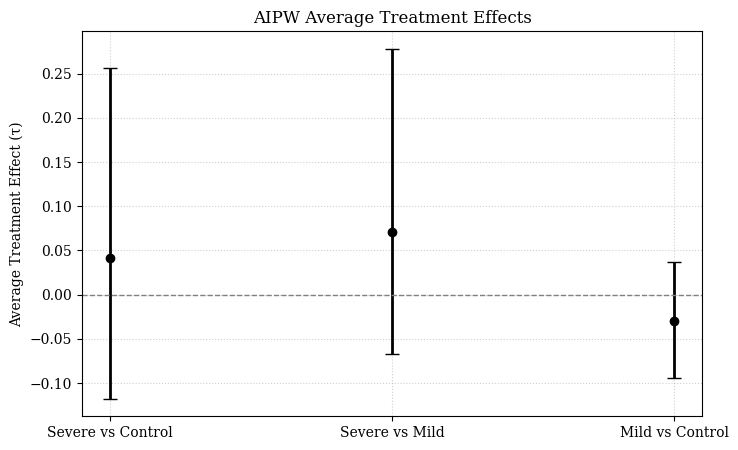

In [53]:
# plot ates from bootsrapped aipw results
order_list = ['2.0 vs 0.0', '2.0 vs 1.0', '1.0 vs 0.0']
reordered_bootstrap = {k: bootstrap_summary[k] for k in order_list}

contrasts = list(reordered_bootstrap.keys())
taus = [reordered_bootstrap[c]["tau"] for c in contrasts]
lowers = [reordered_bootstrap[c]["ci_lower"] for c in contrasts]
uppers = [reordered_bootstrap[c]["ci_upper"] for c in contrasts]

errors = [
    [tau - low for tau, low in zip(taus, lowers)],
    [up - tau for up, tau in zip(uppers, taus)]
]

plt.figure(figsize=(8, 5))
plt.errorbar(['Severe vs Control', 'Severe vs Mild', 'Mild vs Control'], taus, yerr=errors, fmt='o', capsize=5, color='black', ecolor='black', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.ylabel("Average Treatment Effect (τ)")
plt.title("AIPW Average Treatment Effects")
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks()
plt.savefig('../AIPW_Results.png', transparent=True)